本项目首先从豆瓣网站上爬取2018年top250电影评论数据以及相关信息，对爬取信息进行可视化分析总结。

## 加载引用工具包

In [1]:
import requests
from bs4 import BeautifulSoup
import os,socket
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import jieba
from PIL import Image 
from wordcloud import WordCloud
%matplotlib inline

## 创建爬虫类

In [2]:
#创建爬虫
class Spider:
    '''
    本类用于从指定网站上爬取文本信息，并且存储到本地文件
    '''
    def __init__(self,url='https://movie.douban.com/top250',):   #实例化
        self.url = url
        self.header={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36"}
        
    #创建爬虫文件夹
    def mkdir(self,path=None):
        path = path.strip()
        #识别文件路径是否存在
        isExists = os.path.exists('backup')
        if not isExists:
            os.makedirs('backup')#根据文件路径创建文件夹
            
        return os.path.abspath('.')  #返回绝对路径
    #获取Beautifulsoup
    def get_soup(self,link):
        html = requests.get(link, headers=self.header)
        html.encoding = html.apparent_encoding
        soup = BeautifulSoup(html.text,'lxml')
        return soup

## 定义功能函数

In [3]:
def autolabel(rects, ax, xpos='center'): #设置显示每一个条形图的值
    xpos = xpos.lower()  # 规范参数大小写
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() * offset[xpos], 1.01 * height,
                    '{}'.format(height), ha=ha[xpos], va='bottom', size=8.2)



    
#绘制x轴为年份，Y轴为电影数量柱状图
def drawyearplot(num_list,name_list):
        ind = np.arange(len(name_list))
        fig,ax = plt.subplots()   #画板分割
        ax.set_xlabel('year')  #设置横坐标标签
        ax.set_ylabel('numbers')   #设置纵坐标标签
        ax.set_title('Douban top 250 movie numbers by year')  #设置柱形图标题
        
        rext = ax.bar(ind,num_list,color='b',tick_label=name_list)
        autolabel(rext,ax)
        plt.xticks(np.arange(len(name_list)),rotation=60,size=10) #设置x轴坐标属性
        
        fig = plt.gcf()
        fig.set_size_inches(15.5,10.5) #设置图标大小
        #plt.savefig(r"backup\douban_year.png",dip=200)#保存图片到本地
        plt.show()
        plt.close()    
        
def drawcountryplot(cry_list): #绘制x轴为国家，y轴为电影数量的柱状图
        sta={}
        for i in cry_list:
            if not sta.__contains__(i):
                sta[i]=1
            else:
                sta[i]+=1
        num_l =[]  #数量
        country_list=[] #国家地区
        for key,values in sta.items():
            country_list.append(key)
            num_l.append(values)
        
        ind = np.arange(len(country_list))
        fig,ax = plt.subplots()
        ax.set_xlabel('country')
        ax.set_ylabel('movie_numbers')
        ax.set_title('Douban top 250 movie numbers by country')
        
        rext = ax.bar(ind,num_l,color='b',tick_label=country_list)
        autolabel(rext,ax)
        plt.xticks(np.arange(len(country_list)),size=7.2) #设置x轴坐标属性
        
        fig = plt.gcf()
        fig.set_size_inches(15.5,10.5) #设置图标大小
        #plt.savefig(r"backup\douban_country.png",dip=200)#保存图片到本地
        plt.show()
        plt.close()
        
def drawtypeplot(typ_list):     #绘制X轴为电影的标签，Y轴为数量的柱状图
        sta = {}
        for i in typ_list: #统计各个国家的电影数量
            if i not in sta.keys():
                sta[i] = 1
            else:
                sta[i] += 1
        num_l = []  #数量
        tp_list = [] #电影类型
        for key, values in sta.items():
            tp_list.append(key)
            num_l.append(values)       
        ind = np.arange(len(tp_list))
        fig,ax = plt.subplots()
        ax.set_xlabel('type')
        ax.set_ylabel('movie_numbers')
        ax.set_title('Douban top 250 movie numbers by type')
        
        rext = ax.bar(ind,num_l,color='b',tick_label=tp_list)
        autolabel(rext,ax)
        plt.xticks(np.arange(len(tp_list)),size=7.2) #设置x轴坐标属性
        
        fig = plt.gcf()
        fig.set_size_inches(15.5,10.5) #设置图标大小
        #plt.savefig(r"backup\douban_type.png",dip=200)#保存图片到本地
        plt.show()
        plt.close()
        return tp_list

## 爬取评论数据

In [4]:
socket.setdefaulttimeout(20)  #设置超时时间为30s
spider = Spider()
path = spider.mkdir('top250')  #创建top250文件夹路径
print('starting get data from douban...')

starting get data from douban...


In [5]:
# 解析豆瓣top250数据
name_save=[] #存储电影标题
year_save=[] #存储年份
country_save=[]  #存储国家
type_save=[]   #存储电影类别
type_save2 = [] #存储单一电影类别
quote_save = [] #存储电影简评
star_save = [] #存储电影星级
#解决matplotlib 显示中文乱码
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体 SimHei为黑体
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 豆瓣电影翻页
x = 1
for i in range(1,11):
    if i == 1:
        url ='https://movie.douban.com/top250'
    else:
        url = 'https://movie.douban.com/top250'+"?start="+str(25*(i-1))+'&filter='
    main_soup = spider.get_soup(url)
    ol_grid = main_soup.find('ol',class_='grid_view')
    li = ol_grid.find_all('li')

    for l in li:
        em_rank=l.find('em').get_text()
        div_hd = l.find('div',class_='hd')
        a = div_hd.find('a')
        title = a.find('span',class_='title').get_text()
        name_save.append(title)
        #电影评分获取
        div_star = l.find('div',class_='star')
        star_num=div_star.find('span',class_='rating_num').get_text()
        star_save.append(star_num)
        
        #电影信息简介获取
        p_info = l.find('p',class_='').get_text()
        s_c = p_info.split('/')[-2].strip()
        country = s_c.split()[0]
        country_save.append(country)

        #获取电影类型数组
        l_typ = p_info.split('/')[-1].strip()#.split()
        type_save2.append(l_typ)
        for typ in l_typ.split():
            type_save.append(typ)

        s1 = ''.join(p_info.split()) #去掉字符串中的\xa0
        l_s = s1.split('/')
        if x==78:            #大闹天宫多次上映 取最早上映时间
            year = '1961'
        else:
            year = l_s[-3][-4:]  #电影上映年份
        x+=1
        year_save.append(year)
        #获取电影简评
        div_bd = l.find('div', class_='bd')
        q = div_bd.find('span', class_='inq')
        if q != None:
            quote = q.get_text()
            quote_save.append(quote)
        else:
            quote_save.append('None')

In [6]:
import pandas as pd
movie_name = name_save
movie_year = year_save
movie_country = country_save 
movie_type = type_save2
movie_quote = quote_save
movie_star = star_save
movie = {'name':movie_name,'year':movie_year, 'country':movie_country, 'type':movie_type,'quote':movie_quote,'star_num':movie_star}
movie = pd.DataFrame(movie)

In [7]:
#movie.to_csv('doubanmovie_top250.csv')
movie.head()

,name,year,country,type,quote,star_num
0,肖申克的救赎,1994,美国,犯罪 剧情,希望让人自由。,9.6
1,霸王别姬,1993,中国大陆,剧情 爱情 同性,风华绝代。,9.5
2,这个杀手不太冷,1994,法国,剧情 动作 犯罪,怪蜀黍和小萝莉不得不说的故事。,9.4
3,阿甘正传,1994,美国,剧情 爱情,一部美国近现代史。,9.4
4,美丽人生,1997,意大利,剧情 喜剧 爱情 战争,最美的谎言。,9.5


In [10]:
name_list = []
sta = {}
for i in range(1931,2018):  #柱形图x轴坐标
    name_list.append(i)
    sta[str(i)]=0
for x in year_save:#统计从1931到2017每年在榜单中的电影数量
    sta[x] += 1

num_list = []
name_list1 = []
#for key, value in sta.items():
    #if value > 0:       #只显示电影数量大于0的
        #name_list1.append(str(key))
        #num_list.append(value)
        
for item in name_list:
    name_list1.append(str(item))
    value = sta[str(item)]
    num_list.append(value)

## 电影数据图表分析

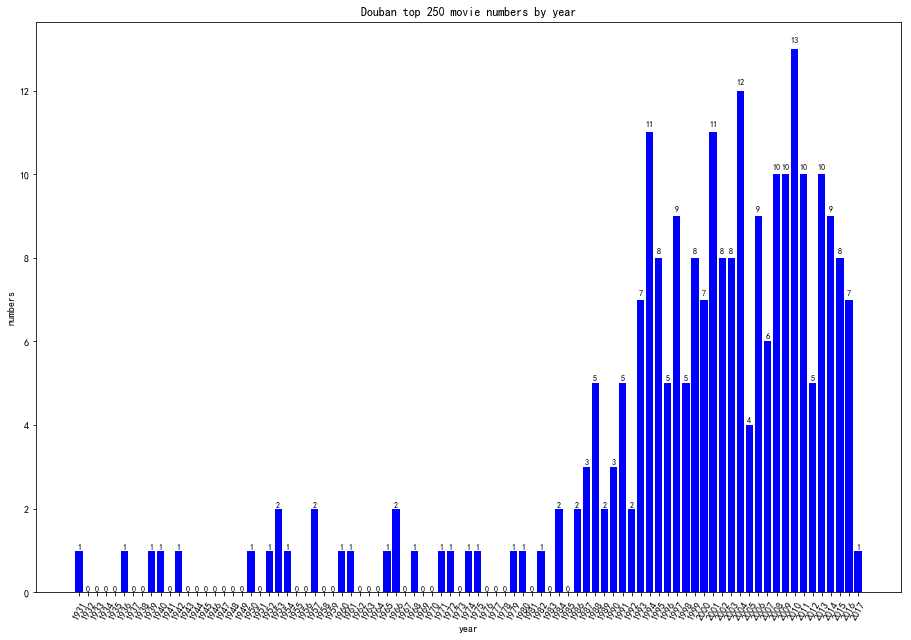

In [11]:
drawyearplot(num_list, name_list)      #电影年份图表

根据上图图示标明，2010年出品的多部电影质量一直有着较高的讨论活跃度，其次是2004年以及2001年，且21世纪以来出品电影占据top250数据绝大部分，反映出随着时代的发展，电影的制作技术，电影质量也随之有了提高，人们对于接收新时代的电影有了更高的认识

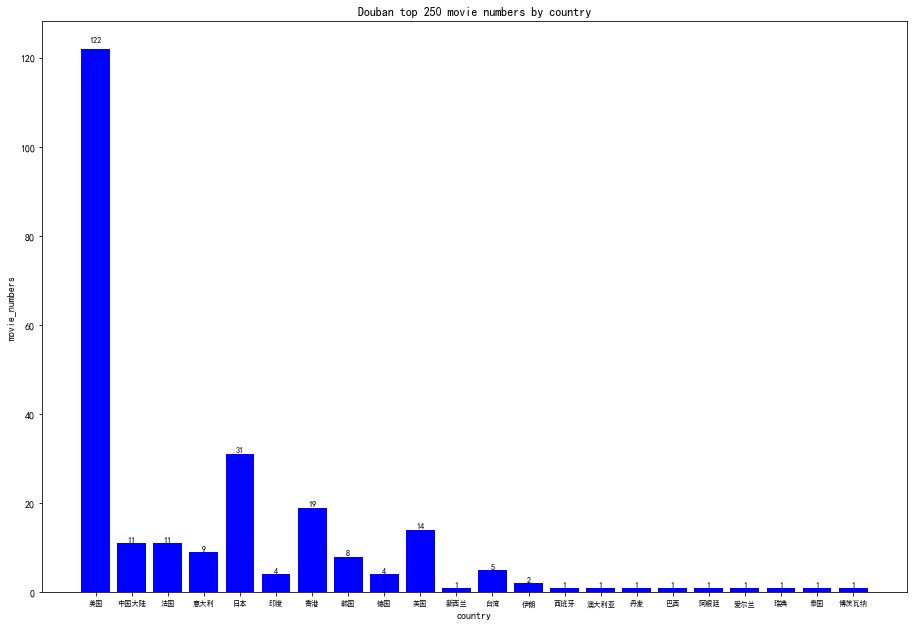

In [12]:
drawcountryplot(country_save)     #电影出品国家图表

根据上图图示表明，美国电影市场仍然占据着世界电影的主导地位，可见美国好莱坞电影的制作质量一直保持着顶尖的水平，人们在观看电影的时候更倾向选择美国好莱坞电影，在剧情，特效，电影质量等方面有着不可撼动的高度，其次日本通过其电影展现出独特的日本文化以及宣扬的哲理，也能够深深捕获人心，导致日本出品电影多次排在top250行列之中，另外港片的质量也在豆瓣影迷心中占据着一定地位，尤其表现在90年代港片的黄金时期，许多场景许多电影经典语录对人们有着深深影响，导致其多部经典电影常年上榜在豆瓣top250行列之中。

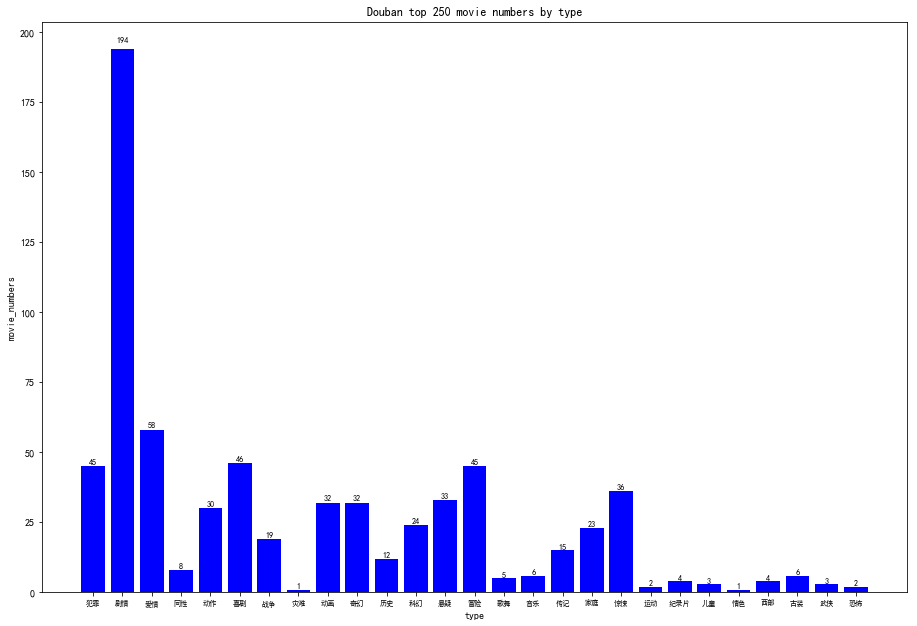

In [13]:
drawtypeplot(type_save)   #电影类型图表

根据上图图示表明，剧情类电影在豆瓣电影top250深受影迷群众喜爱，该类型的讨论活跃度以及评分上榜数量遥遥领先于其他类型电影，其次是爱情，喜剧类型电影，反映出群众能否对电影印象深刻离不开一个好的故事主干，大家对于剧情类电影所拍摄出的人性百态，社会哲理更容易深入人心，另外电影对情感的探索，积极向上乐观的态度也是能够深深打动影迷的重要一部分。